In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind
from matplotlib.offsetbox import AnchoredText
import os
# Load the data
file_path = 'Data/VPC.xlsx'
df = pd.read_excel(file_path)

# Delete the VPC and VPCID columns' contents
df.loc['VPCID'] = pd.NA
df.loc['VPC'] = pd.NA

# Create a composite key combining 'ID' and 'Cohort'
df['Composite_Key'] = df['Cohort'].astype(str) + '-' + df['ID'].astype(str)

# Filter and exclude certain rows based on Age, FluPositive, and Time
age_filter = (df['Age'].isna()) | ((df['Age'] >= 18.0) & (df['Age'] <= 45.0))
flu_positive_filter = (df['FluPositive'] == 1) | (df['FluPositive'].isna())
time_filter = (df['Time'].isna()) | (df['Time'] >= 0) & (df['Time'] <= 14)

# Combine all filters
combined_filter = age_filter & flu_positive_filter & time_filter

df.loc[~combined_filter, 'VPC'] = 0
df.loc[combined_filter, 'VPC'] = 1
remaining_patients = df[df['VPC'] != 0].drop_duplicates(subset='Composite_Key')
remaining_patients['VPCID'] = range(0, len(remaining_patients))

# Update the original DataFrame with new VPCIDs
for _, row in remaining_patients.iterrows():
    df.loc[df['Composite_Key'] == row['Composite_Key'], 'VPCID'] = row['VPCID']

df.to_excel(file_path, index=False) # Save the modified DataFrame

# Load only VPC == 1 (included data) into a new DataFrame
VPC = df[df['VPC'] == 1]

Summary Statistics for VPC DataFrame for Cohort Hopkins:
Total Age Records: 252, Unknown Age Records: 252
Total Sex Records: 252, Unknown Sex Records: 0


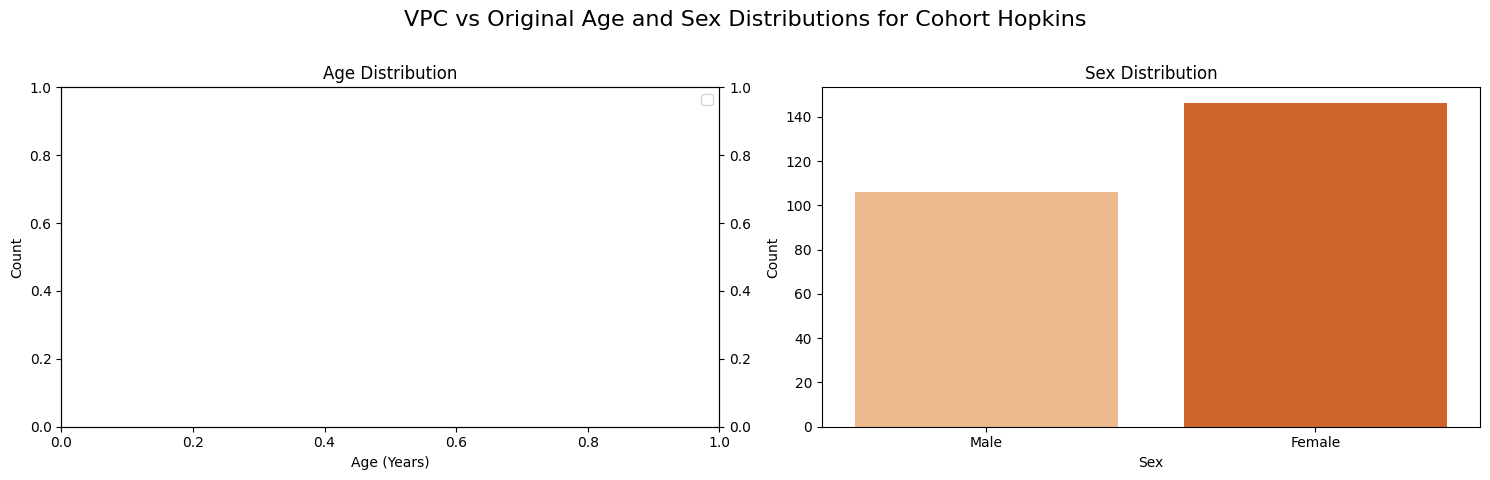

Summary Statistics for VPC DataFrame for Cohort Taiwan:
Total Age Records: 192, Unknown Age Records: 192
Total Sex Records: 192, Unknown Sex Records: 0


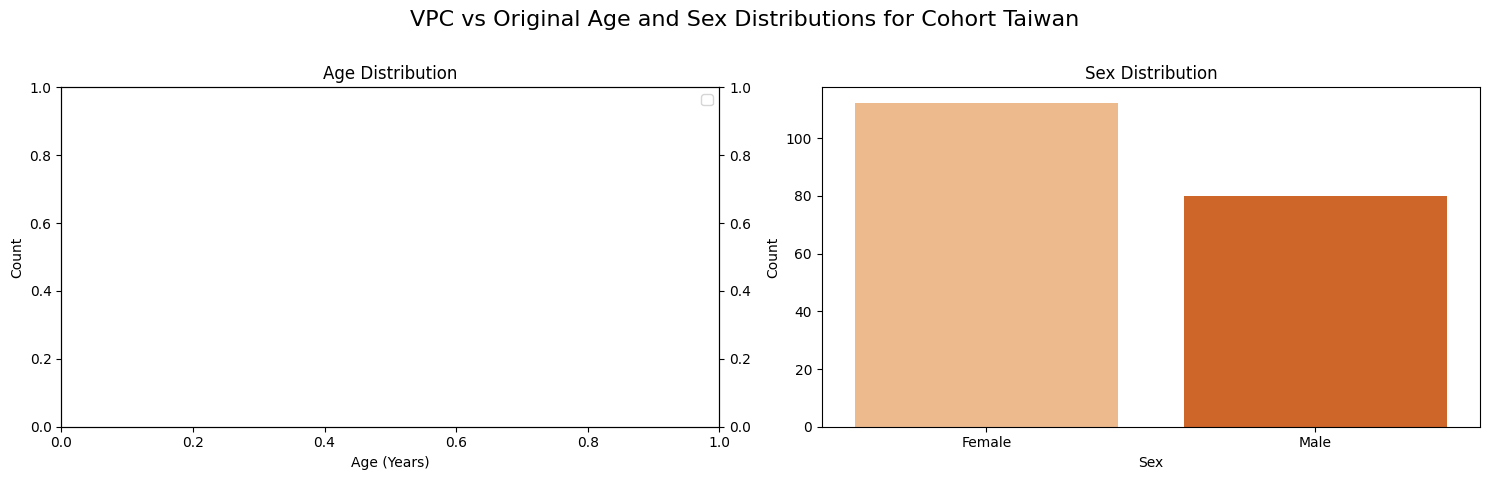

Summary Statistics for VPC DataFrame for Cohort FLU09:
Total Age Records: 40, Unknown Age Records: 0
Total Sex Records: 40, Unknown Sex Records: 0


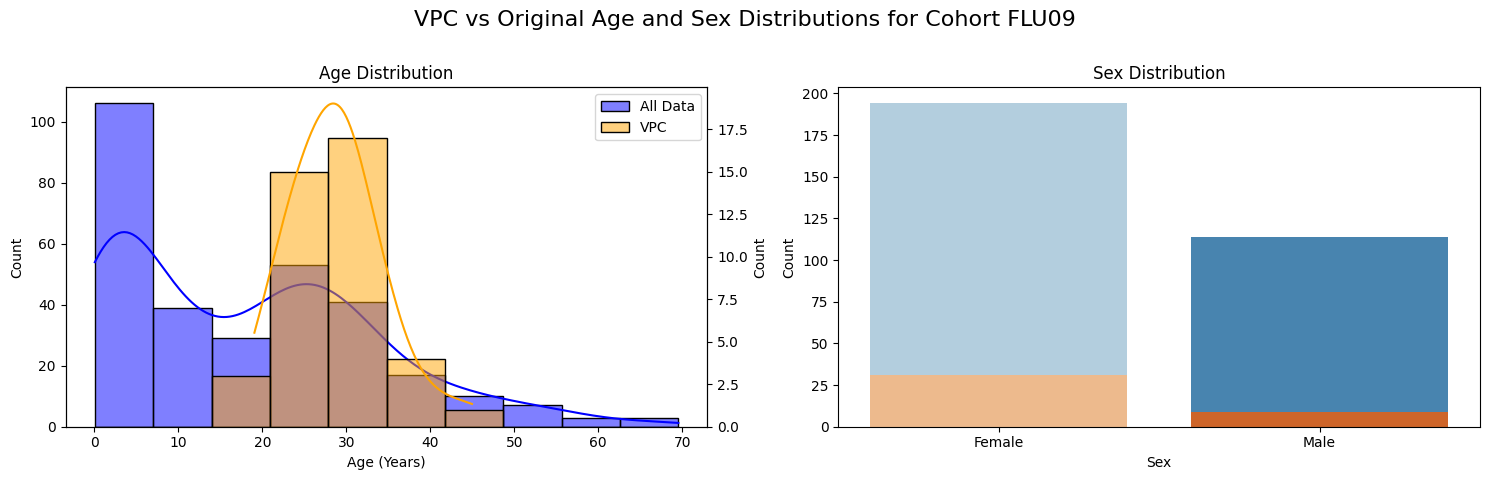

Summary Statistics for VPC DataFrame for Cohort Memphis:
Total Age Records: 1045, Unknown Age Records: 1019
Total Sex Records: 1045, Unknown Sex Records: 1045


ValueError: min() arg is an empty sequence

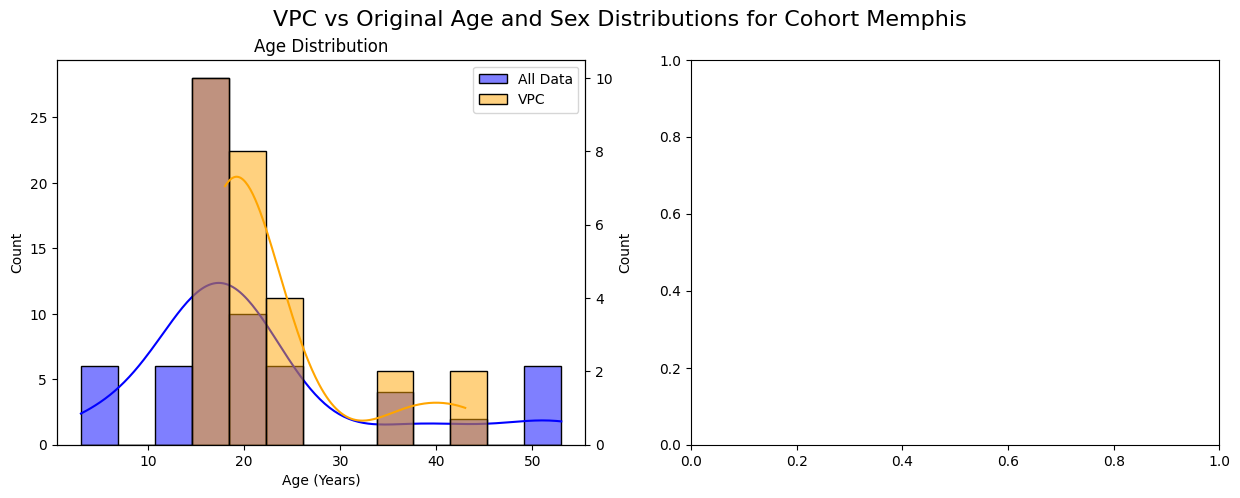

In [6]:
# Get unique cohorts
cohorts = ['Hopkins', 'Taiwan', 'FLU09', 'Memphis']

# Loop through each cohort
for cohort in cohorts:
    # Filter both df and VPC to this Cohort
    df_cohort = df[df['Cohort'] == cohort]
    VPC_cohort = VPC[VPC['Cohort'] == cohort]

    # Summary statistics for unknowns in Age and Sex for VPC DataFrame
    unknown_age_count_vpc = VPC_cohort['Age'].isna().sum()
    total_age_count_vpc = len(VPC_cohort['Age'])
    unknown_sex_count_vpc = VPC_cohort['Sex'].isna().sum()
    total_sex_count_vpc = len(VPC_cohort['Sex'])

    print(f"Summary Statistics for VPC DataFrame for Cohort {cohort}:")
    print(f"Total Age Records: {total_age_count_vpc}, Unknown Age Records: {unknown_age_count_vpc}")
    print(f"Total Sex Records: {total_sex_count_vpc}, Unknown Sex Records: {unknown_sex_count_vpc}")

    # Creating subplots for each status to analyze known Age and Sex distribution
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'VPC vs Original Age and Sex Distributions for Cohort {cohort}', fontsize=16)

    # Age distribution for known data
    # Automatically calculating the number of bins
    bins = np.histogram_bin_edges(df_cohort['Age'].dropna(), bins='auto')

    sns.histplot(df_cohort['Age'].dropna(), ax=axes[0], kde=True, bins=bins, color='blue', label='All Data') # All Data
    ax_age = axes[0].twinx()
    sns.histplot(VPC_cohort['Age'].dropna(), ax=ax_age, kde=True, bins=bins, color='orange', label='VPC') # VPC-selected

    # Restoring the VPC to the legend
    lines, labels = axes[0].get_legend_handles_labels()
    lines2, labels2 = ax_age.get_legend_handles_labels()
    axes[0].legend(lines + lines2, labels + labels2)

    axes[0].set_title('Age Distribution')
    axes[0].set_xlabel('Age (Years)')
    axes[0].set_ylabel('Count')

    # Sex distribution for known data
    df_known_sex = df_cohort.dropna(subset=['Sex'])
    VPC_known_sex = VPC_cohort.dropna(subset=['Sex'])
    sns.countplot(x='Sex', data=df_known_sex, ax=axes[1], palette='Blues', label='All Data')
    sns.countplot(x='Sex', data=VPC_known_sex, ax=axes[1], palette='Oranges', label='VPC-selected')
    axes[1].set_title('Sex Distribution')
    axes[1].set_xlabel('Sex')
    axes[1].set_ylabel('Count')

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    #plt.savefig(f'vpc_vs_original_distribution_cohort_{cohort}.svg')
    plt.show()


In [13]:
# Prepare plotting
output_folder = 'plots'
os.makedirs(output_folder, exist_ok=True)

# List of metadata and outcome columns
metadata_cols = ['Sex']
outcome_cols = [col for col in df.columns if col.endswith('.N') or col.endswith('.P')]  # List all your outcome columns here

# Ensure the columns are numeric and replace NaNs with a small number (e.g., 1e-10)
for col in outcome_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Apply log10 transformation
df[outcome_cols] = np.log10(df[outcome_cols].clip(lower=0)+1)

# Metadata columns
metadata_cols = ['VPCID','Time','Time Category','VPC','Year','Cohort','Reference','DOI','ID','Age','Sex','Ethnicity','Status','FluPositive','Strain']

# cytokines of interest
cytokines = [
    "GCSF.N",
    "GCSF.P",
    "GM-CSF.N",
    "GM-CSF.P",
    "IFNα2.N",
    "IFNα2.P",
    "IFNγ.N",
    "IFNγ.P",
    "IL10.N",
    "IL10.P",
    "IL1β.N",
    "IL1β.P",
    "IL6.N",
    "IL6.P",
    "MCP1.N",
    "MCP1.P",
    "MCP3.N",
    "MCP3.P",
    "MDC.N",
    "MDC.P",
    "MIP1α.N",
    "MIP1α.P",
    "MIP1β.N",
    "MIP1β.P",
    "TGFα.N",
    "TGFα.P",
    "TNFα.N",
    "TNFα.P",
    "TNFβ.N",
    "TNFβ.P"
]

# Cut the dataframe down to only the metadata cols and Cytokines of interest
VPC = VPC[metadata_cols + cytokines]

In [ ]:

def plot_data_by_category(df, column, category, output_folder):
    # Filter data for the specific column
    data = df[[category, column]].dropna()

    # Replace 0 with NaN for log transformation
    data[column].replace(0, np.nan, inplace=True)
    data = data.dropna(subset=[column])

    # Creating the plot
    plt.figure(figsize=(10, 6))
    sns.stripplot(x=category, y=column, data=data, size=10, edgecolor='black',
                  palette={'Male': 'green', 'Female': 'purple'}, hue=category, zorder=1)

    # Calculate mean and standard deviation for each category
    means = data.groupby(category)[column].mean()
    stds = data.groupby(category)[column].std()

    for cat in data[category].unique():
        mean = means[cat]
        std = stds[cat]
        i = list(data[category].unique()).index(cat)
        plt.errorbar(i, mean, yerr=std, fmt='none', color='black', capsize=10, elinewidth=2, capthick=2, zorder=2)
        plt.hlines(mean, xmin=i-0.4, xmax=i+0.4, colors='black', linestyles='solid', zorder=2)

    # T-test and p-value (if both categories are present)
    
    if len(data[category].unique()) > 1:
        cat1_data = data[data[category] == data[category].unique()[0]][column]
        cat2_data = data[data[category] == data[category].unique()[1]][column]
        t_stat, p_value = ttest_ind(cat1_data, cat2_data)
        significance = "*" if p_value < 0.05 else ""
        anchored_text = AnchoredText(f'p = {p_value:.2e} {significance}', loc='upper center')
        plt.gca().add_artist(anchored_text)

    # Setting labels and title
    plt.ylabel(f'Log10 {column} Relative Luminescence')
    plt.title(f'{column} by {category}')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(False)

    # If the t-test is significant, change the filename to indicate it
    try:
        if significance:
            plot_filename = os.path.join(output_folder, f'{column}_by_{category}_SIGNFICANT.svg')
            plt.savefig(plot_filename)
            plt.show()
        else:
            plot_filename = os.path.join(output_folder, f'{column}_by_{category}.svg')
            plt.savefig(plot_filename)
            plt.close()
    except:
        print('Insufficient data for', column, 'by', category)
#  plotting and statistical tests for All Cohorts combined
for cytokine in cytokines:
    plot_data_by_category(df, cytokine, 'Sex', output_folder)

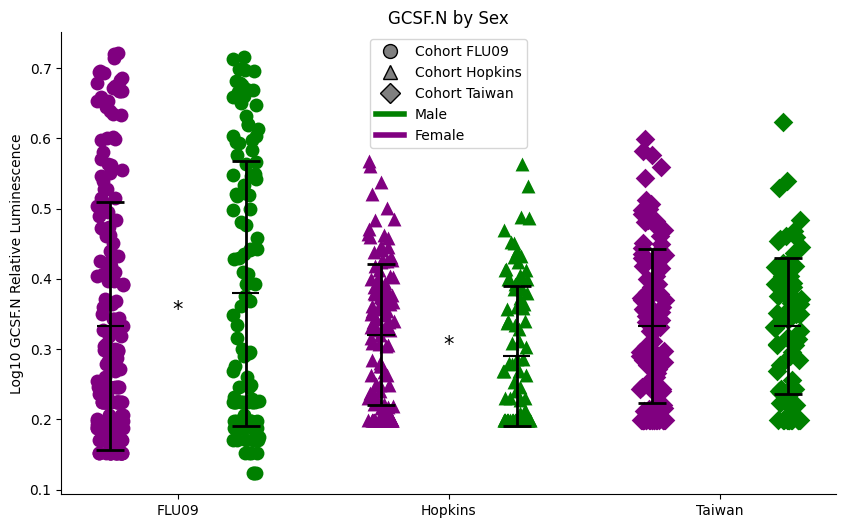

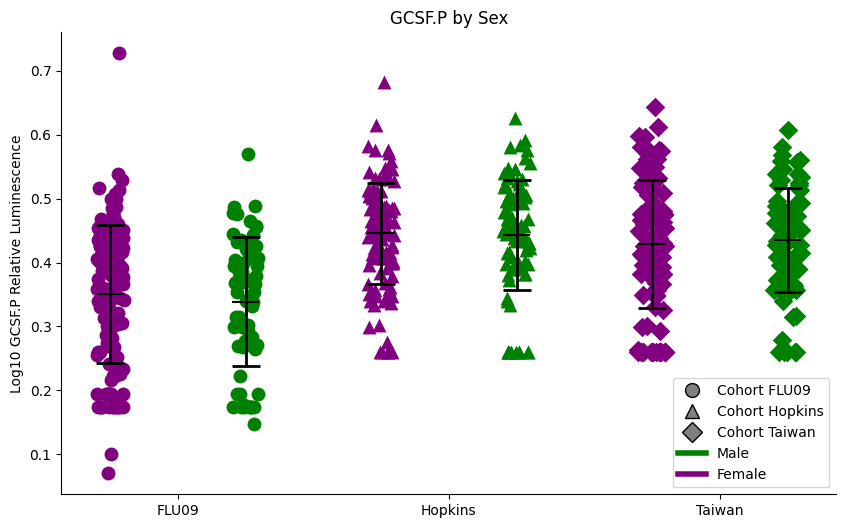

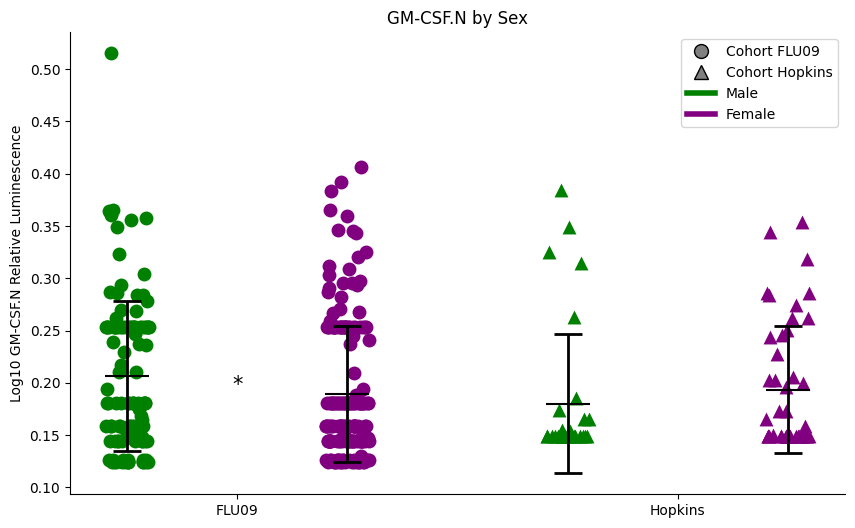

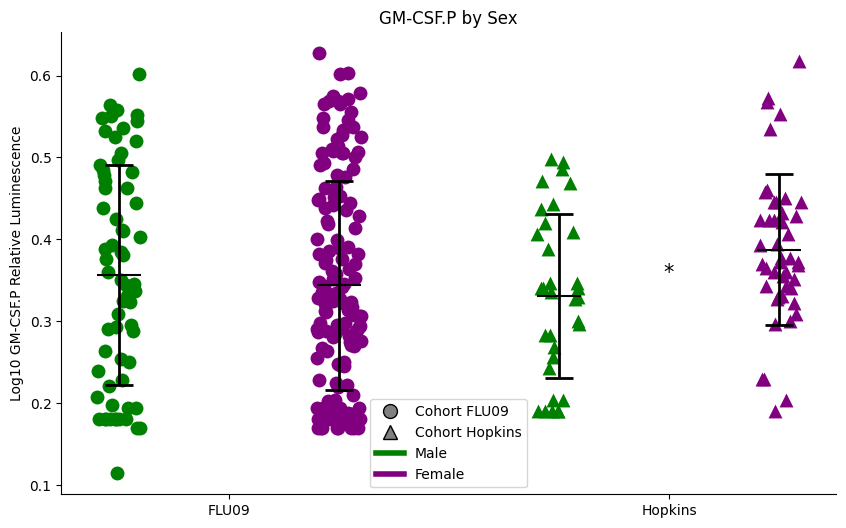

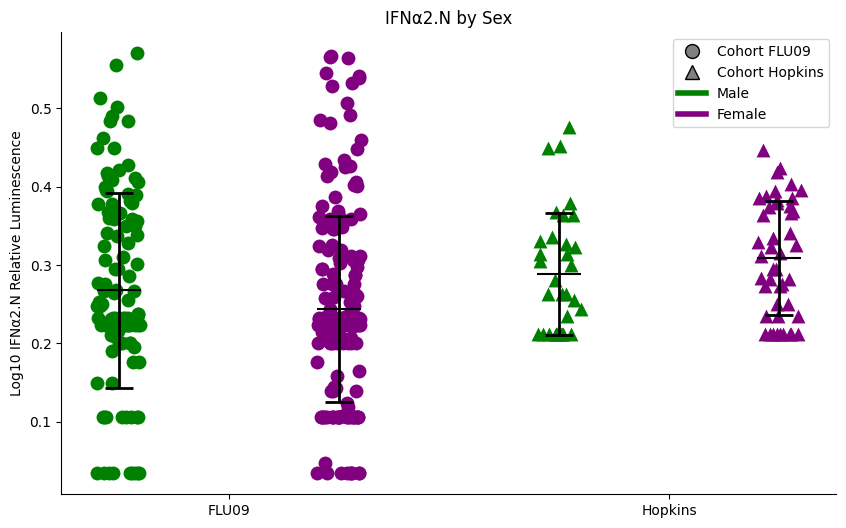

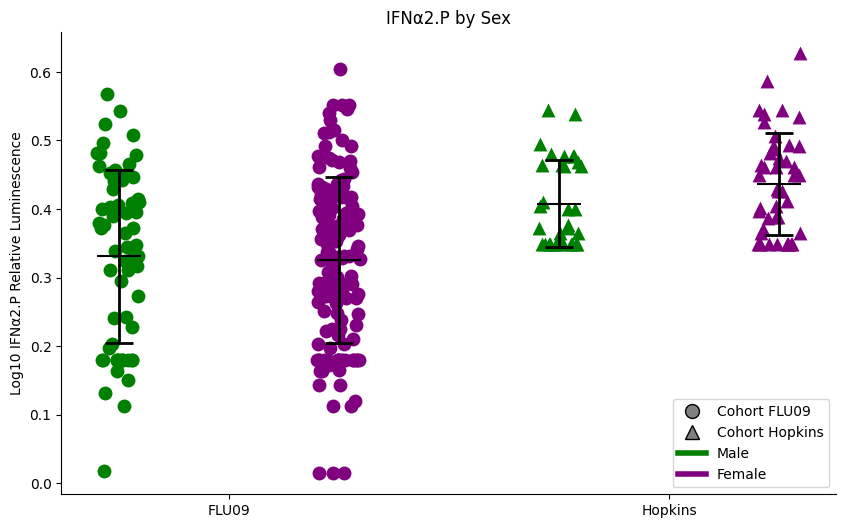

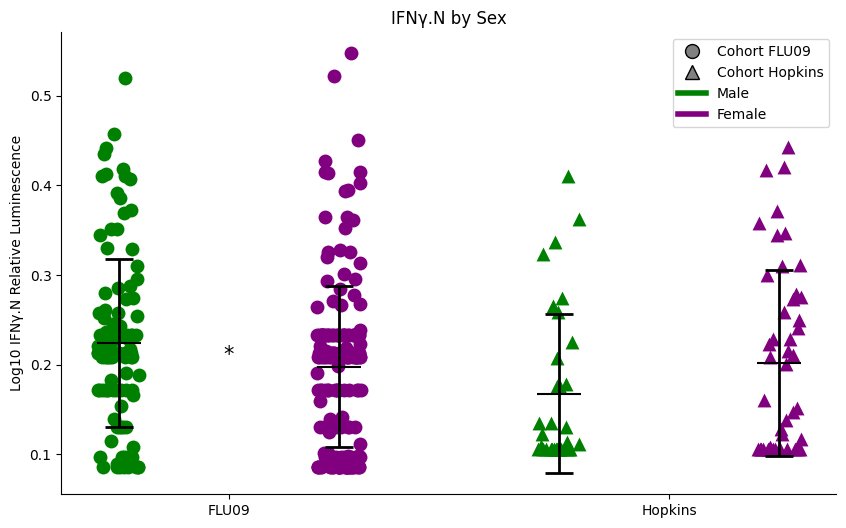

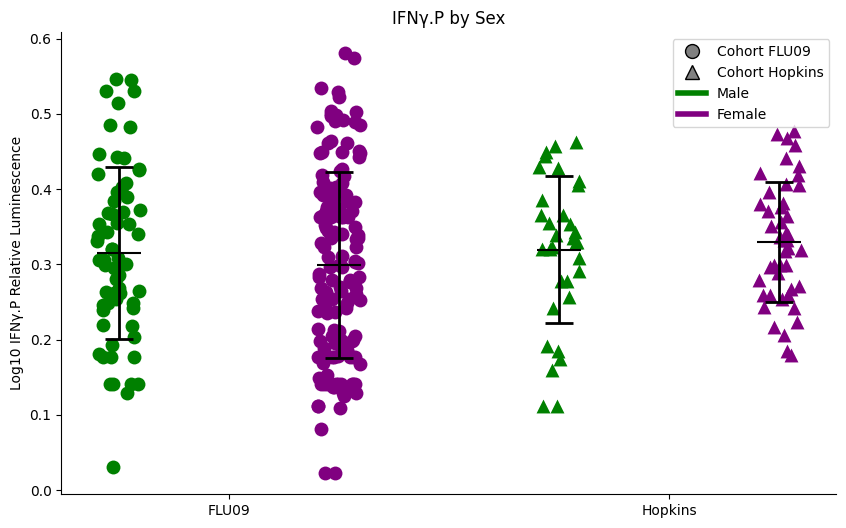

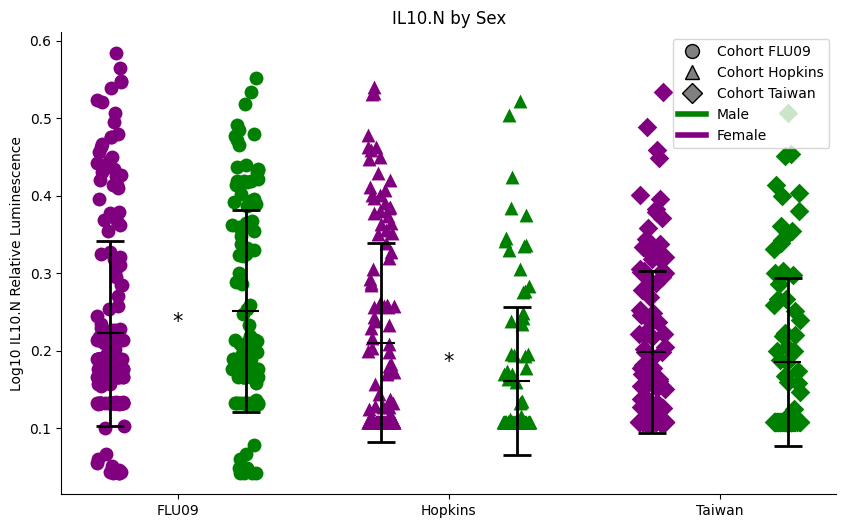

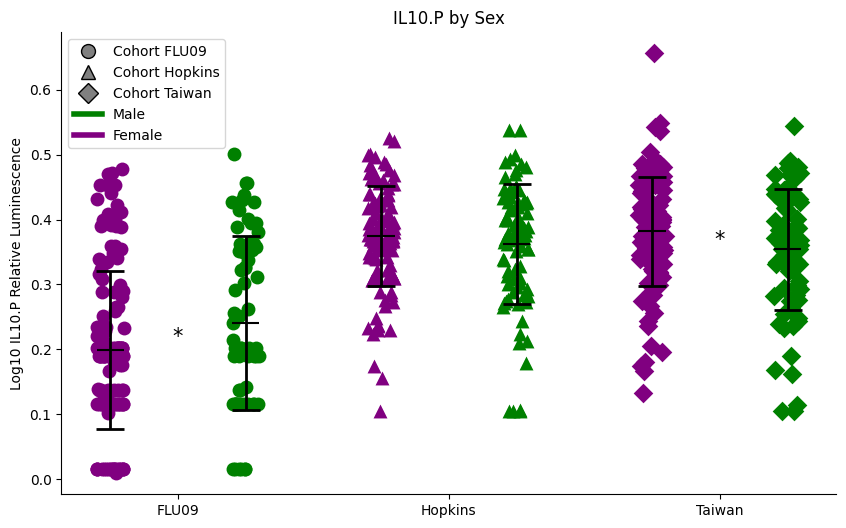

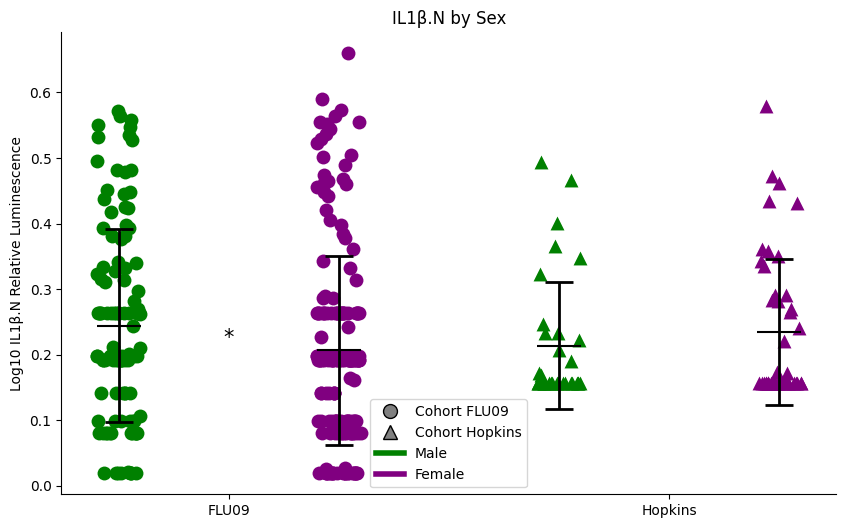

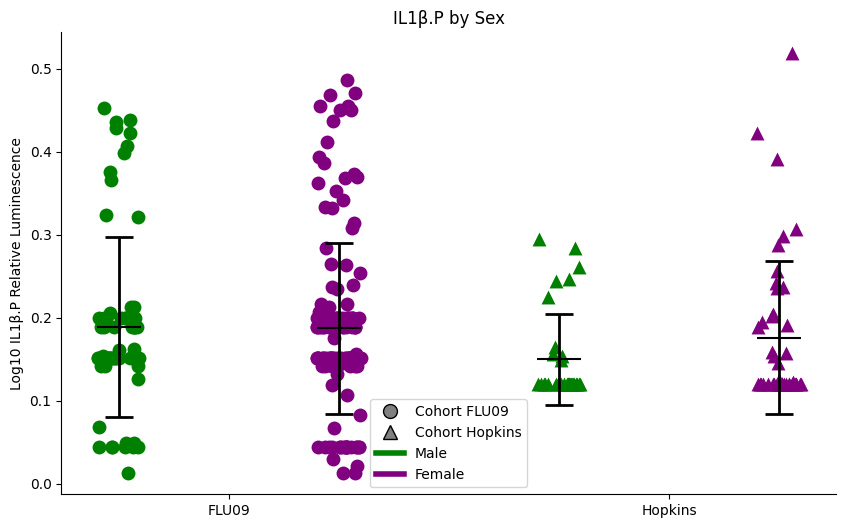

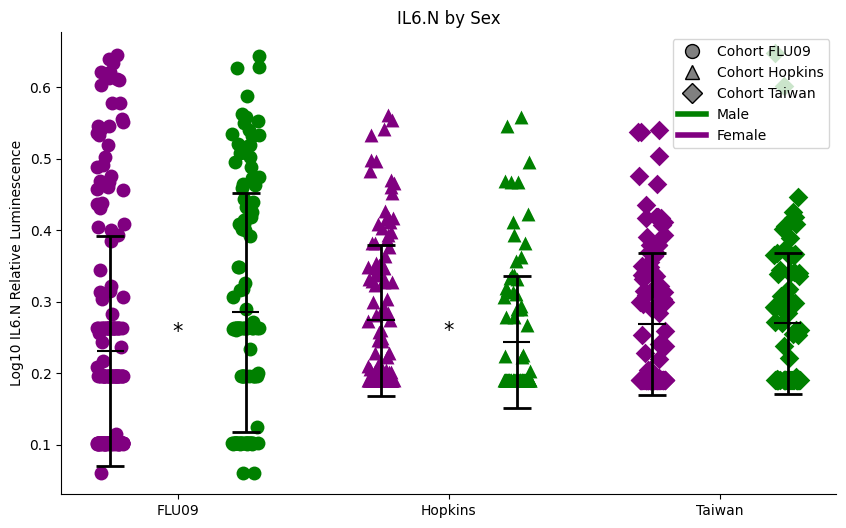

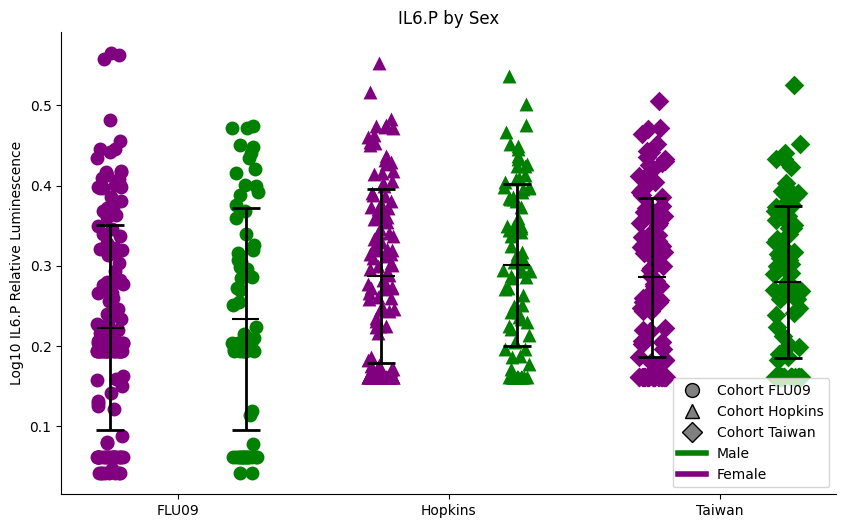

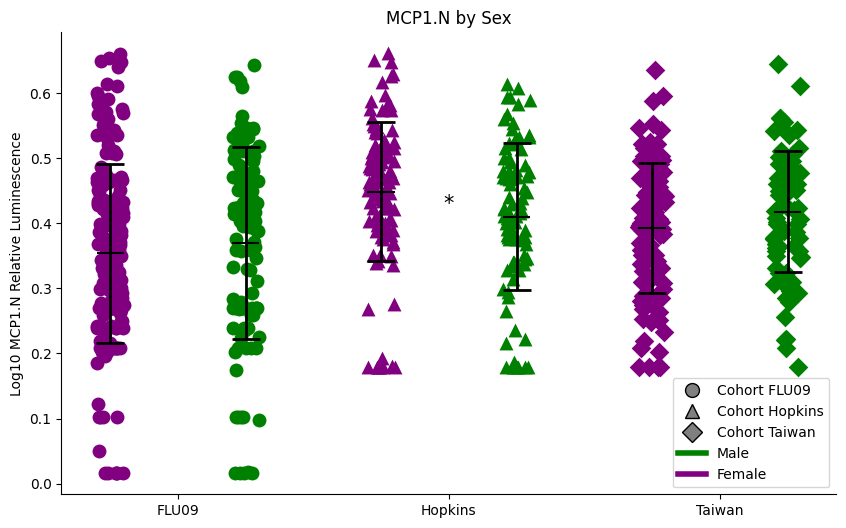

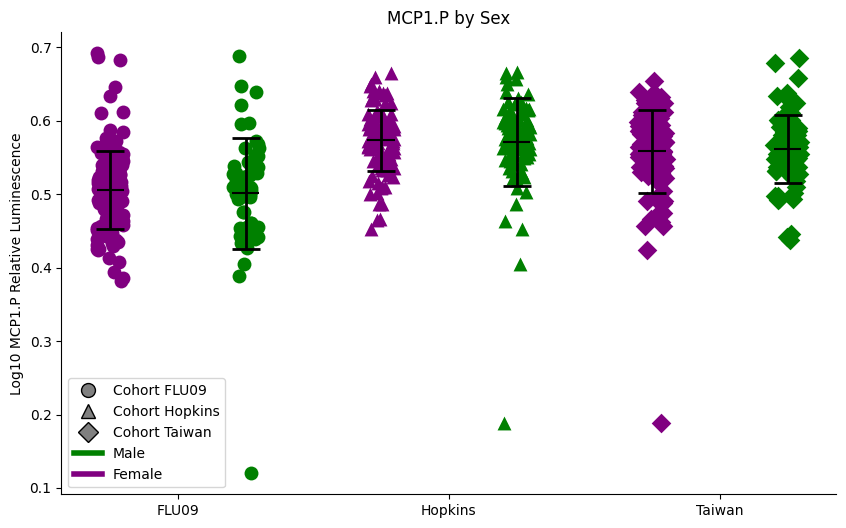

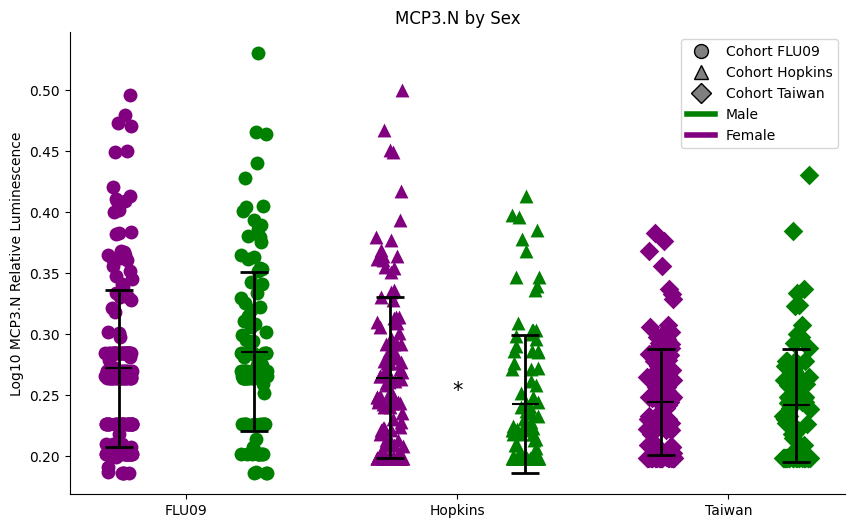

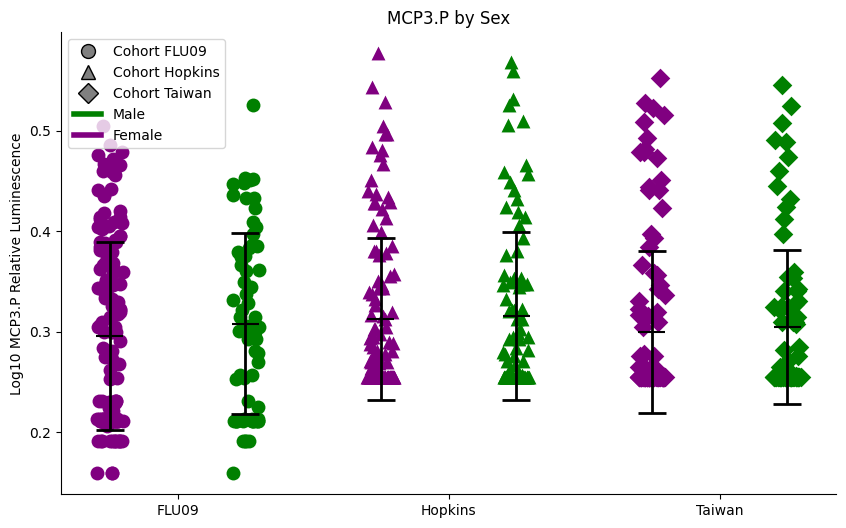

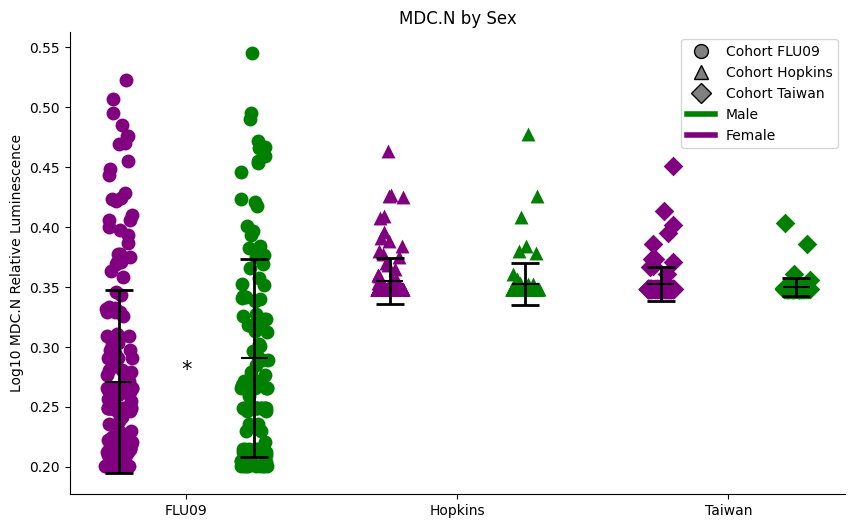

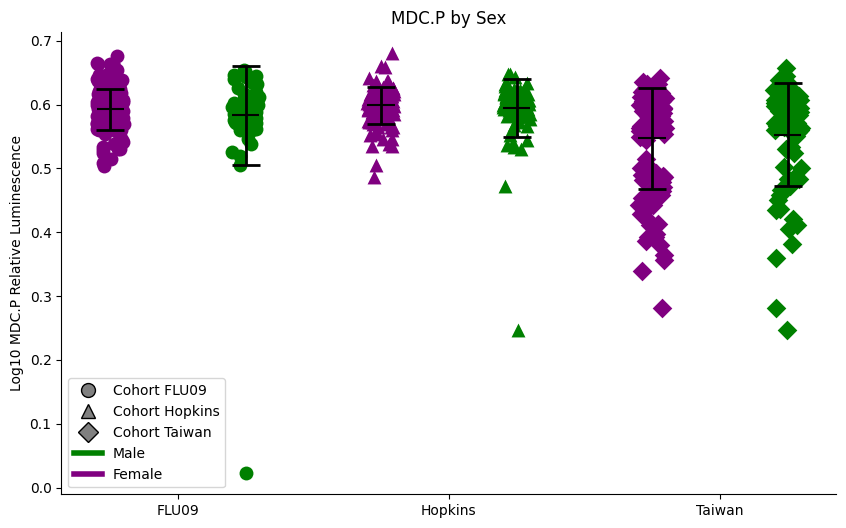

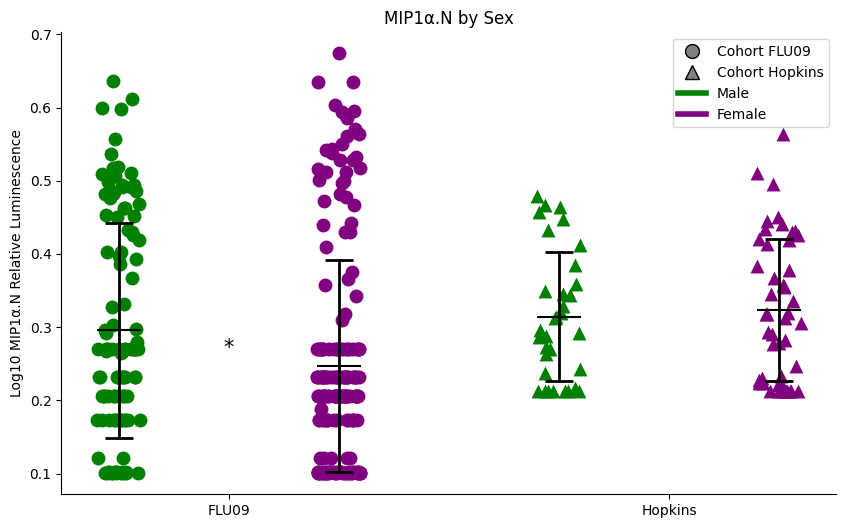

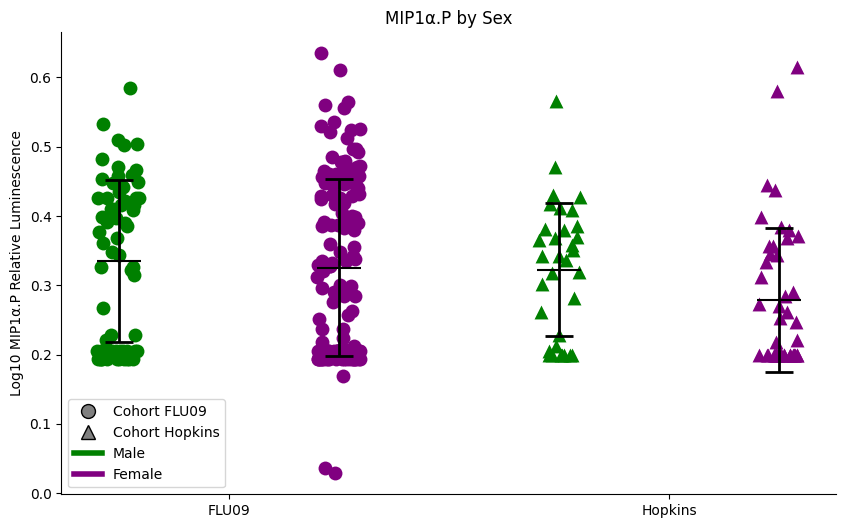

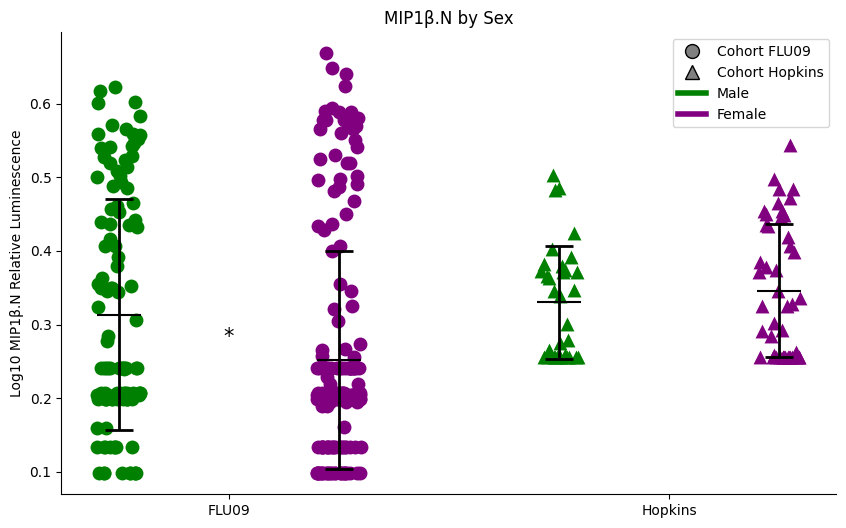

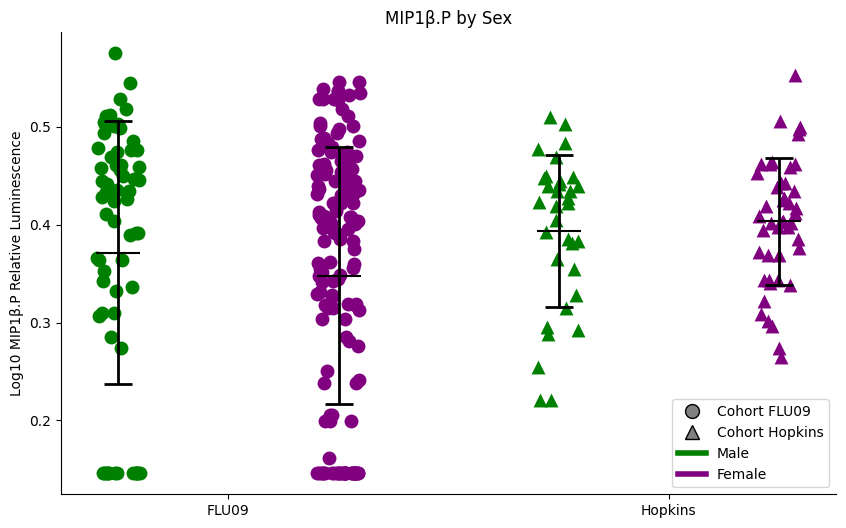

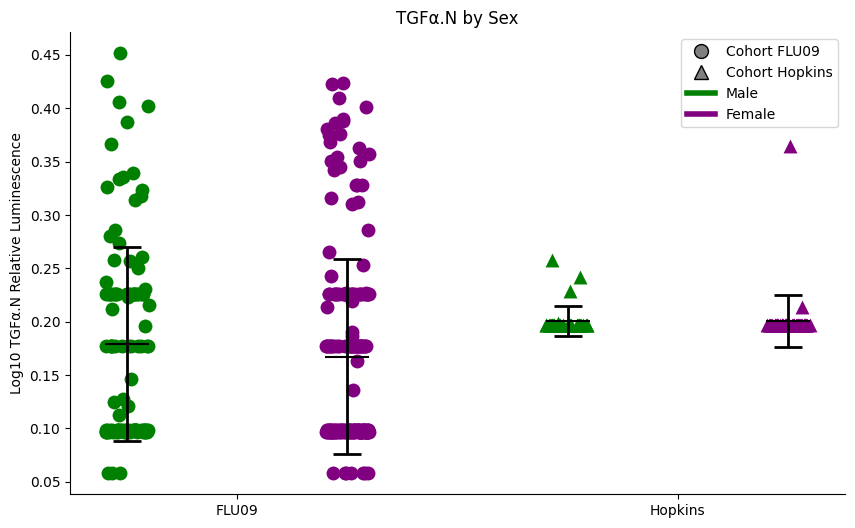

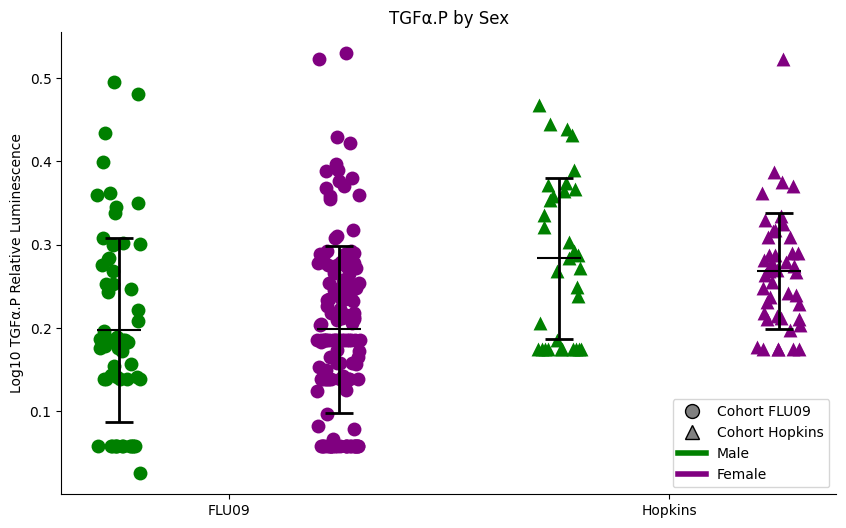

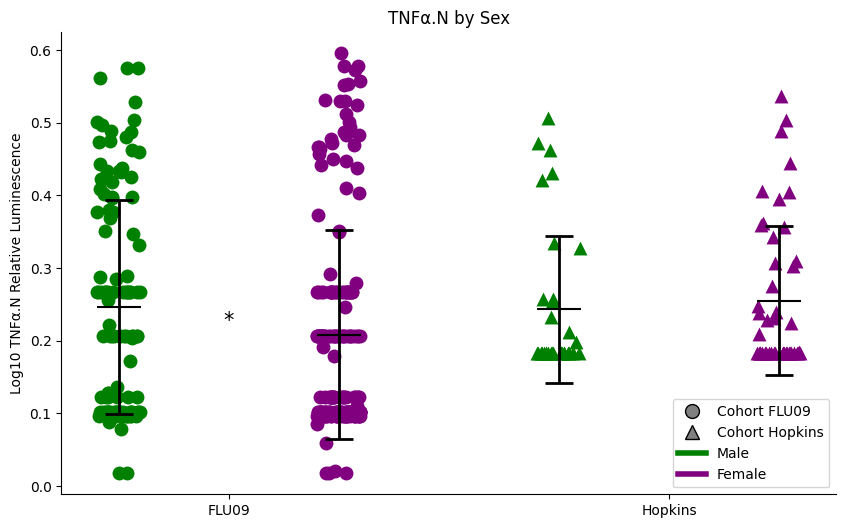

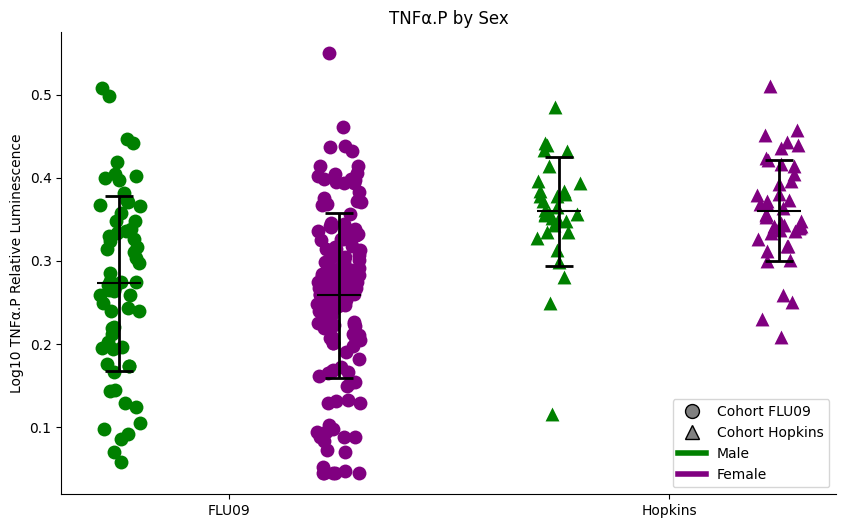

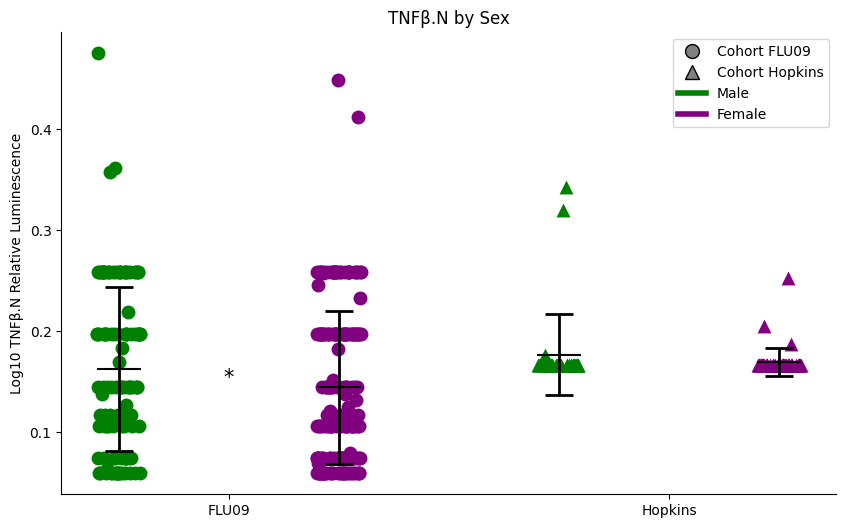

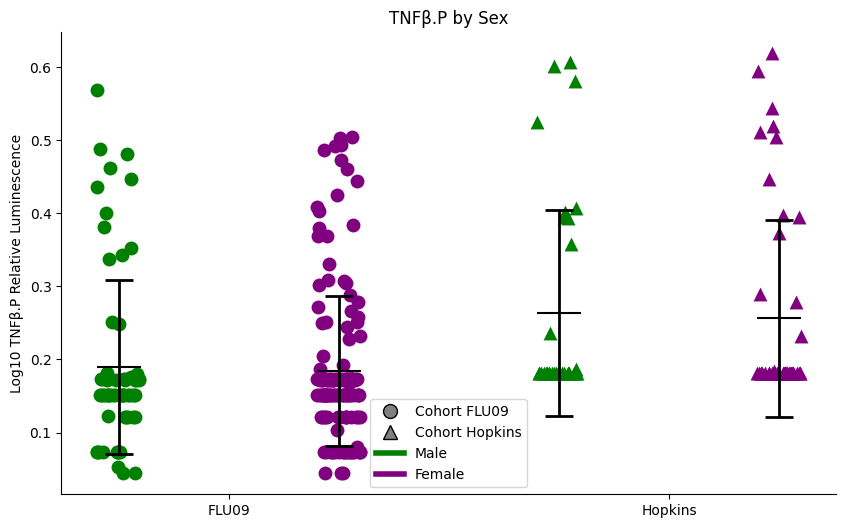

In [38]:
# Cytokine By Sex and Cohort

def plot_data_by_category(df, column, category, cohort_col, output_folder):
    if cohort_col not in df.columns:
        print(f"'{cohort_col}' column not found in dataframe.")
        return

    data = df[[category, cohort_col, column]].dropna()
    data[column].replace(0, np.nan, inplace=True)
    data = data.dropna(subset=[column])

    cohorts = sorted(data[cohort_col].unique())
    categories = data[category].unique()
    max_cohorts = len(cohorts)

    cohort_indices = {cohort: index for index, cohort in enumerate(cohorts)}
    markers = ['o', '^', 'D']
    cohort_markers = dict(zip(cohorts, markers[:len(cohorts)]))

    plt.figure(figsize=(10, 6))
    ax = plt.gca()

    base_offset = 0.2 
    offset = base_offset / max_cohorts

    sex_colors = {'Male': 'green', 'Female': 'purple'}
    for cohort in cohorts:
        means = []  # Store means for each sex in the cohort
        for cat in categories:
            subset = data[(data[cohort_col] == cohort) & (data[category] == cat)]
            mean = subset[column].mean()
            means.append(mean)  # Append mean to the list
            std = subset[column].std()
            cat_index = list(categories).index(cat)
            cohort_index = cohort_indices[cohort]
            pos = cohort_index * 2 + cat_index
            sns.stripplot(x=[pos] * len(subset), y=subset[column], size=10, edgecolor='black', 
                        marker=cohort_markers[cohort], color=sex_colors[cat], ax=ax, zorder=1)
            plt.errorbar(pos, mean, yerr=std, fmt='none', color='black', capsize=10, elinewidth=2, capthick=2, zorder=3)
            plt.hlines(mean, xmin=pos-0.1, xmax=pos+0.1, colors='black', linestyles='solid', zorder=2)

        # T-Tests for each cohort and placing the marker
        if len(categories) > 1:
            male_data = data[(data[cohort_col] == cohort) & (data[category] == 'Male')][column]
            female_data = data[(data[cohort_col] == cohort) & (data[category] == 'Female')][column]
            t_stat, p_value = ttest_ind(male_data, female_data, nan_policy='omit')
            if p_value < 0.05:
                mean_of_means = np.mean(means)
                plt.text(cohort_index * 2 + 0.5, mean_of_means, '*', fontsize=15, ha='center', va='center', zorder=4)

    plt.xticks(np.arange(0, max_cohorts * 2, 2) + 0.5, cohorts)
    ax.set_xticklabels(cohorts, ha='center')

    legend_elements = [plt.Line2D([0], [0], marker=m, color='w', label=f'Cohort {c}', markersize=10, markerfacecolor='gray', markeredgecolor='black') for c, m in cohort_markers.items()]
    legend_elements += [plt.Line2D([0], [0], color='green', lw=4, label='Male'), plt.Line2D([0], [0], color='purple', lw=4, label='Female')]
    ax.legend(handles=legend_elements)

    plt.ylabel(f'Log10 {column} Relative Luminescence')
    plt.title(f'{column} by {category}')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(False)

    plot_filename = os.path.join(output_folder, f'{column}_by_{category}_and_Cohort.svg')
    plt.savefig(plot_filename)
    plt.show()
    plt.close()
    

for cytokine in cytokines:
    plot_data_by_category(df, cytokine, 'Sex', 'Cohort', output_folder)

In [42]:
import pandas as pd

def compute_statistics(df, cytokines, category, cohort_col):
    summary = []

    for cytokine in cytokines:
        data = df[[category, cohort_col, cytokine]].dropna()
        cohorts = sorted(data[cohort_col].unique())
        categories = data[category].unique()

        for cohort in cohorts:
            stats = {'Cytokine': cytokine, 'Cohort': cohort}
            means = []
            sds = []

            for cat in categories:
                subset = data[(data[cohort_col] == cohort) & (data[category] == cat)]
                mean = subset[cytokine].mean()
                sd = subset[cytokine].std()
                stats[f'{cat} Mean'] = mean
                stats[f'{cat} SD'] = sd
                means.append(mean)
                sds.append(sd)

            if len(categories) > 1:
                male_data = data[(data[cohort_col] == cohort) & (data[category] == 'Male')][cytokine]
                female_data = data[(data[cohort_col] == cohort) & (data[category] == 'Female')][cytokine]
                t_stat, p_value = ttest_ind(male_data, female_data, nan_policy='omit')
                stats['P-Value'] = p_value
                stats['Significant'] = p_value < 0.05

            summary.append(stats)

    summary_df = pd.DataFrame(summary)
    return summary_df

# Usage
statistical_summary = compute_statistics(df, cytokines, 'Sex', 'Cohort')
statistical_summary.to_csv('cytokine_statistical_summary.csv', index=False)

# filepath of the output
# Load the summary data
file_path = 'cytokine_statistical_summary.csv'
summary_df = pd.read_csv(file_path)

# Process the data to extract necessary information for the table
table_data = []

for cytokine in summary_df['Cytokine'].unique():
    cytokine_data = summary_df[summary_df['Cytokine'] == cytokine]
    row = {'Cytokine': cytokine}
    for cohort in cytokine_data['Cohort'].unique():
        cohort_data = cytokine_data[cytokine_data['Cohort'] == cohort]
        if cohort_data.empty:
            continue

        # Assume the categories are 'Male' and 'Female'
        male_mean = cohort_data['Male Mean'].values[0]
        female_mean = cohort_data['Female Mean'].values[0]
        p_value = cohort_data['P-Value'].values[0]
        significant = cohort_data['Significant'].values[0]

        if pd.isna(p_value):
            difference = "NA"
        elif significant:
            if male_mean > female_mean:
                difference = f"M>F (p<{p_value:.2f})"
            else:
                difference = f"F>M (p<{p_value:.2f})"
        else:
            difference = "="

        row[f'Cohort {cohort}'] = difference

    table_data.append(row)

# Convert to DataFrame for a structured view
table_df = pd.DataFrame(table_data)
table_df.head()  # Displaying a preview of the table data
# save the file
table_df.to_csv('cytokine_statistical_summary_table.csv', index=False)
